# Práctica 1 - LIDAR

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
import numpy as np
import matplotlib.cm as cm
from tqdm import tqdm
import re
import math
import cv2
from natsort import natsorted 

## Parte 1 - Clustering de una nube de puntos

En la primera parte de la práctica vamos a centrarnos en clusterizar vehículas en una nube de puntos generada por un lidar. Usaremos los algoritmos DB Scan y K-Means.

Primero vamos a crear un método para filtrar los puntos y eliminar los puntos que no nos vayan a ser útiles. También tendrá un parámetro que nos permitirá obtener los puntos pertenecientes al suelo para usarlo en las representaciones gráficas.

In [2]:
def filterPointCloud(dataset, targetRoad=False, minimumYDist = 2, maximumYDist=5.62):

        if(not targetRoad):
                dataset = dataset[dataset['z'] < 2.5] 
                dataset = dataset[dataset['z'] > -2.5] 

                dataset = dataset[dataset['y'] < maximumYDist + (dataset['x'] * 0.065)] 
                dataset = dataset[dataset['y'] > minimumYDist] 

                dataset = dataset[dataset['x'] < 20] 
        else:
                dataset = dataset[dataset['z'] < 5] 
                dataset = dataset[dataset['z'] > -5] 

                dataset = dataset[dataset['y'] > maximumYDist + (dataset['x'] * 0.065)]

                dataset = dataset[dataset['x'] < 20]  
                
        return dataset

También crearemos un método para leer y representar la nube de puntos.

In [3]:
def paintPointCloud(datasetPath, filter=False):
    pointcloud = pd.read_csv(datasetPath)
    if(filter):
        pointcloud = filterPointCloud(pointcloud, targetRoad=False)

    pointcloudnp = pointcloud.to_numpy()

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection='3d')

    plt.xlim(25, -25)
    plt.ylim(25, -25)
    ax.set_zlim(25, -25)

    ax.scatter(pointcloudnp[:, 0], -pointcloudnp[:, 2], pointcloudnp[:, 1], c=pointcloudnp[: ,3], cmap="RdBu", s=0.01)
    plt.show()


Y vamos a visualizar el resultado de los filtrar y representar las nubes de puntos proporcionadas.

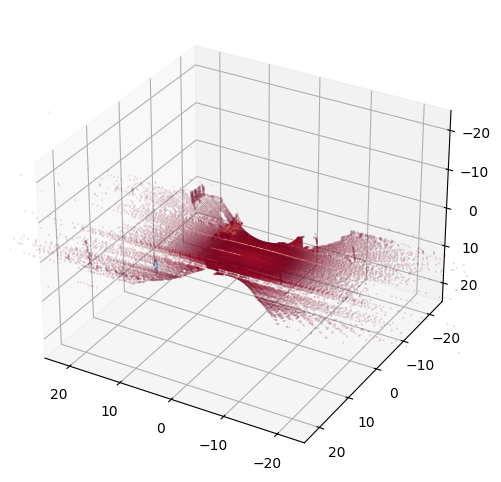

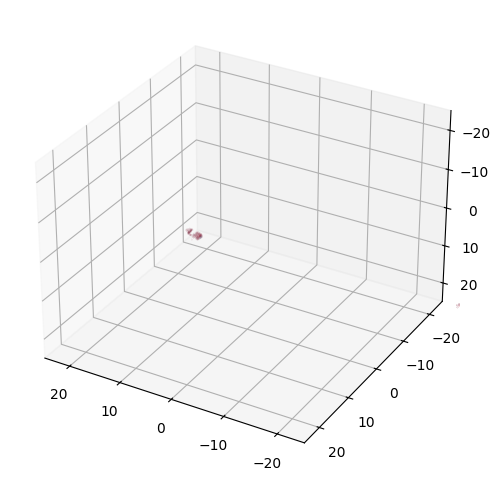

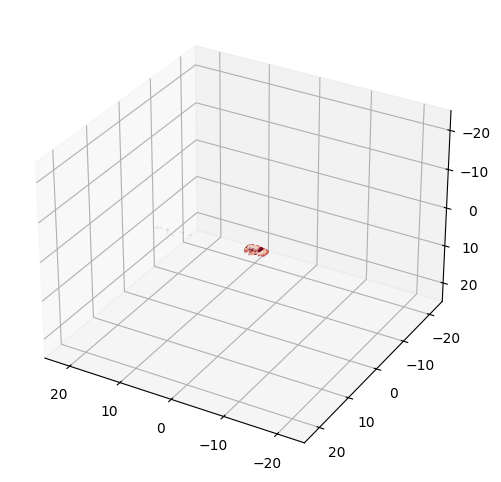

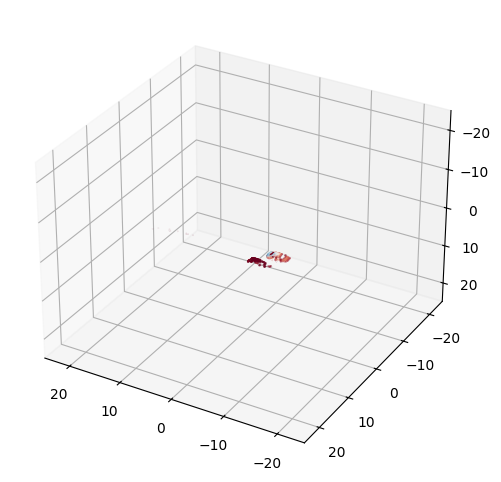

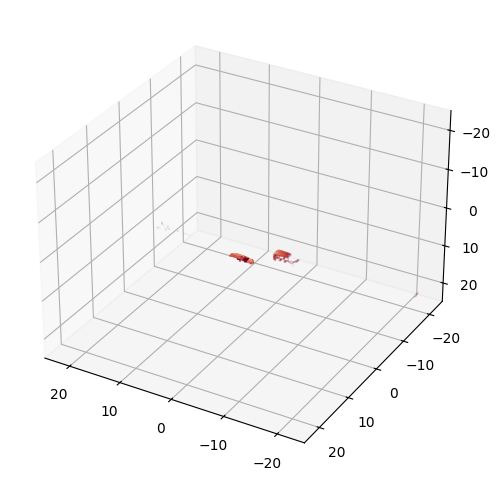

In [4]:
# Pointcloud sin vehículos
paintPointCloud("./data/carretera.csv", filter=False)

paintPointCloud("./data/pointcloud_1686138334837467970.csv", filter=True)
paintPointCloud("./data/1_coche.csv", filter=True)
paintPointCloud("./data/coche_coche.csv", filter=True)
paintPointCloud("./data/coche_coche_moto.csv", filter=True)

Ahora vamos crear un método que use el algoritmo DB Scan para clusterizar las nubes de puntos filtradas, obteniendo un conjunto de clusters que representan los vehículos en la carretera.

In [5]:
def ClusterPointCloudDBScan(datasetPath, showResults=True, filter=True, imageSize=8, imageSavePath="./results/plt.png", vehicleCMap="Reds"):
    pointcloud = pd.read_csv(datasetPath)
    
    if(filter):
        pointcloudRoad = filterPointCloud(pointcloud, targetRoad=True)[["x", "y", "z", "intensity"]].to_numpy()
        pointcloud = filterPointCloud(pointcloud)

    pointcloud = pointcloud[["x", "y", "z"]].to_numpy()

    # Crea un objeto DBSCAN
    dbscan = DBSCAN(eps=0.8, min_samples=10)

    # Aplica el algoritmo
    y_dbscan = dbscan.fit_predict(pointcloud)

    if(showResults):
        # Visualizar los resultados
        fig = plt.figure(figsize=(imageSize, imageSize))
        ax = fig.add_subplot(projection='3d')

        plt.xlim(25, -25)
        plt.ylim(25, -25)
        ax.set_zlim(25, -25)

        if(filter):
            ax.scatter(pointcloudRoad[:, 0], -pointcloudRoad[:, 2], pointcloudRoad[:, 1], c=pointcloudRoad[:, 3], cmap='Greys_r', s = 0.005, alpha = 0.3)
        ax.scatter(pointcloud[:, 0], -pointcloud[:, 2], pointcloud[:, 1], c=y_dbscan, cmap="rainbow", s = 0.2, alpha = 1)
        plt.title("DBSCAN Clustering")
        plt.savefig(imageSavePath)
        plt.show()

    # Devolver el número de clusters, eliminando 1 por el conjunto de outliers
    if(-1 in y_dbscan):
        return len(np.unique(y_dbscan)) - 1
    else:
        return len(np.unique(y_dbscan))

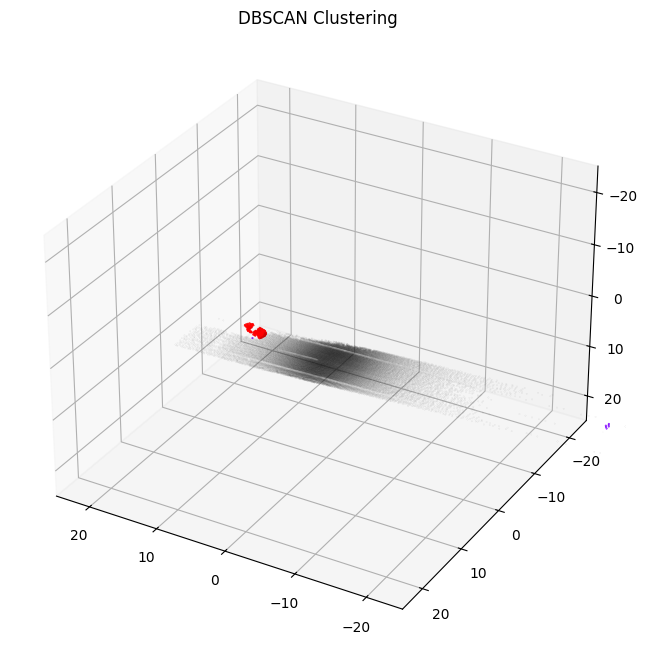

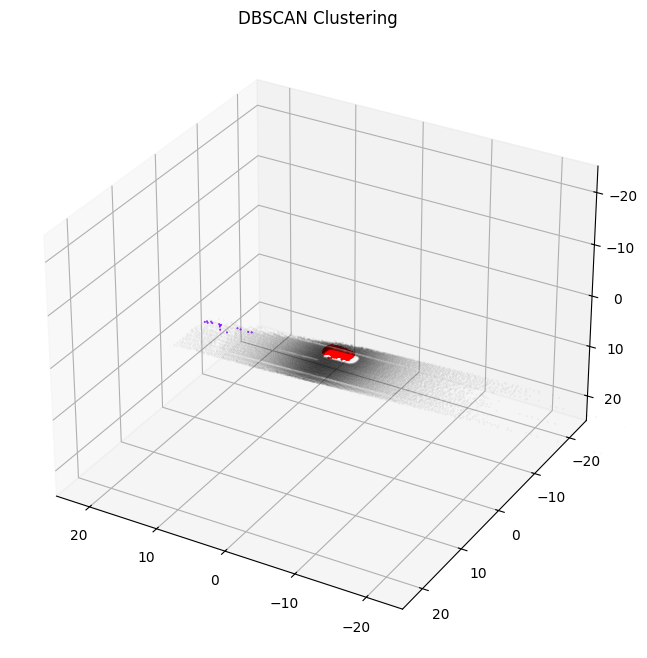

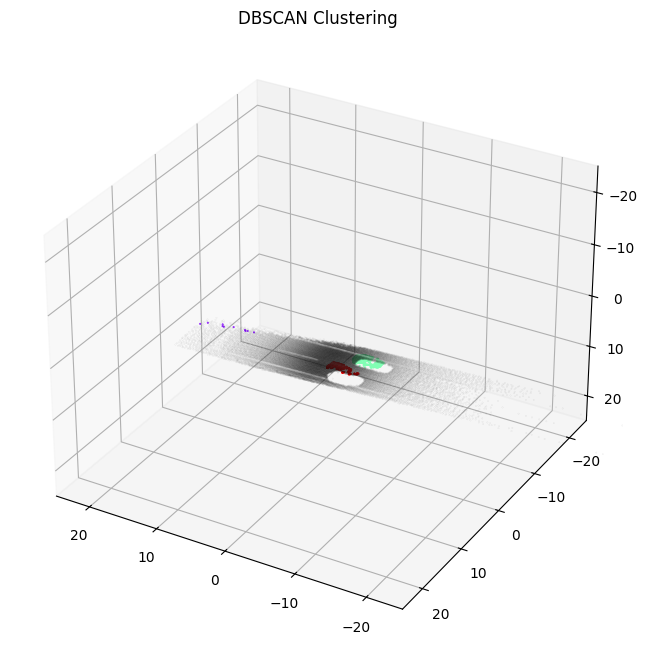

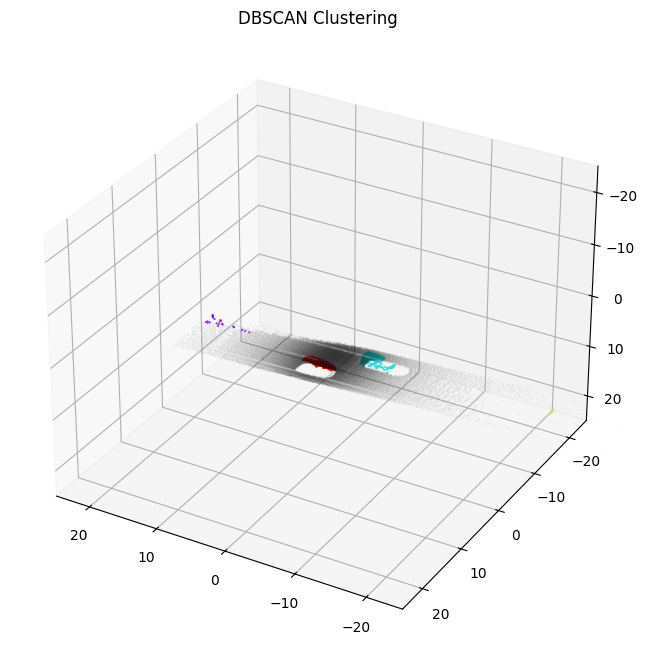

3

In [6]:
ClusterPointCloudDBScan("./data/pointcloud_1686138334837467970.csv")
ClusterPointCloudDBScan("./data/1_coche.csv")
ClusterPointCloudDBScan("./data/coche_coche.csv")
ClusterPointCloudDBScan("./data/coche_coche_moto.csv")

Ahora haremos lo mismo con K-Means. Para este algoritmo necesitamos especificar el número de clusters a generar, el cual vamos a obtener gracias al método con DB Scan implementado previamente.

In [7]:
def ClusterPointCloudKMeans(datasetPath):

    numCluster = ClusterPointCloudDBScan(datasetPath, showResults=False)

    pointcloud = pd.read_csv(datasetPath)

    pointcloudRoad = filterPointCloud(pointcloud, targetRoad=True)[["x", "y", "z", "intensity"]].to_numpy()
    pointcloud = filterPointCloud(pointcloud)

    pointcloud = pointcloud[["x", "y", "z"]].to_numpy()

    # Crea un objeto KMeans
    kmeans = KMeans(n_clusters=numCluster, random_state=0, max_iter=1)

    # Aplica el algoritmo
    kmeans.fit(pointcloud)

    # Obtiene los centroides y las etiquetas de los clústeres
    centroides = kmeans.cluster_centers_
    etiquetas = kmeans.labels_

    # Visualiza los resultados
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')

    plt.xlim(25, -25)
    plt.ylim(25, -25)
    ax.set_zlim(25, -25)

    ax.scatter(pointcloudRoad[:, 0], -pointcloudRoad[:, 2], pointcloudRoad[:, 1], c=pointcloudRoad[:, 3], cmap='Greys_r', s = 0.005, alpha = 0.35)
    ax.scatter(pointcloud[:, 0], -pointcloud[:, 2], pointcloud[:, 1], c=etiquetas, cmap='rainbow', s = 0.2, alpha = 1)
    ax.scatter(centroides[:, 0], -centroides[:, 2], centroides[:, 1], marker=(4, 0, 45), s=2500, color='red', alpha = 0.35)

    for centroide in range(centroides.shape[0]):
        ax.scatter(centroides[centroide, 0], -centroides[centroide, 2], centroides[centroide, 1] - 8, marker=f"$Vehículo\ {centroide + 1}$", s=3000, color='red', alpha = 1)

    plt.title("KMEANS Clustering")
    plt.show()

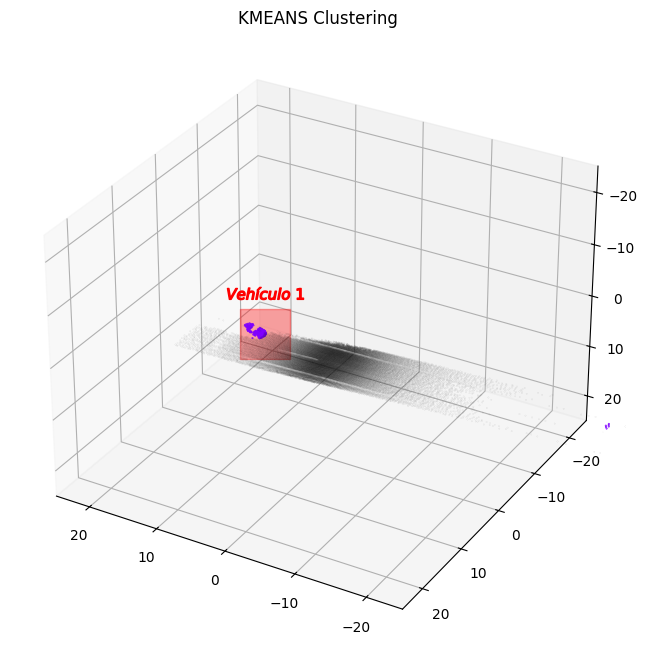

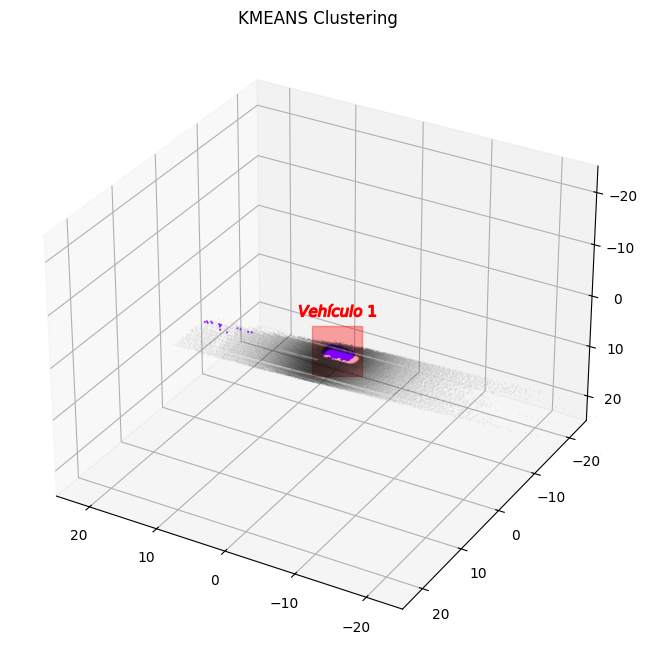

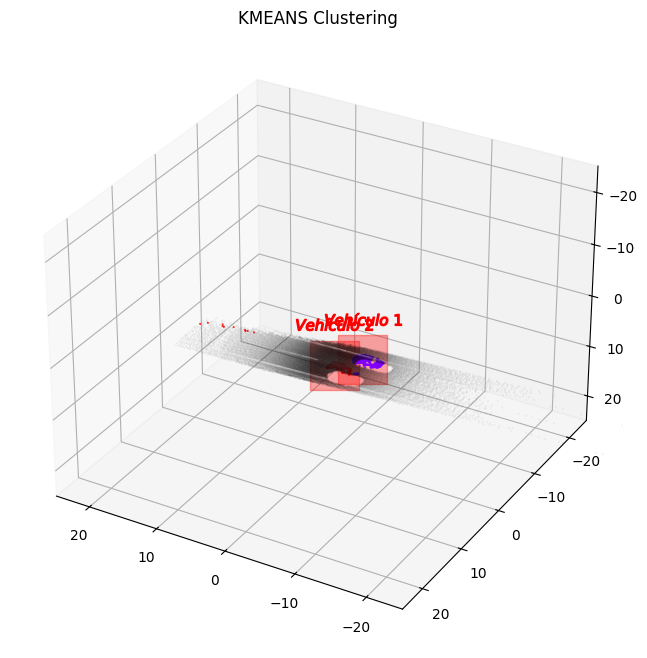

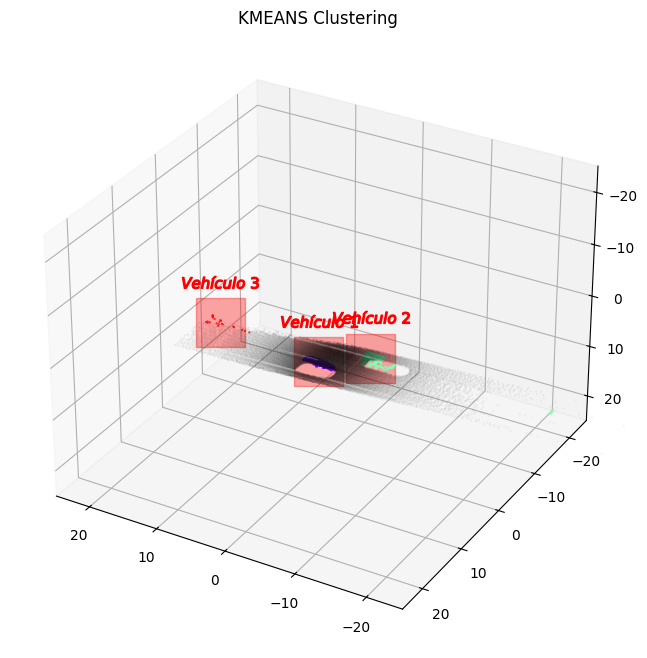

In [8]:
ClusterPointCloudKMeans("./data/pointcloud_1686138334837467970.csv")
ClusterPointCloudKMeans("./data/1_coche.csv")
ClusterPointCloudKMeans("./data/coche_coche.csv")
ClusterPointCloudKMeans("./data/coche_coche_moto.csv")

## Parte 2 - Tracking

En la segunda parte de la práctica aplicaremos los conceptos vistos en la primera sobre una serie temporal de nubes de puntos. Sobre este conjunto de nubes de puntos aplicaremos tracking, manteniendo constancia de los diferentes vehículos a lo largo del tiempo, es decir, cada vehículo tendrá un id que permanecerá constante de una nube de puntos a la siguiente. En esta parte de la práctica se ha usado únicamente DB Scan.

El siguiente código renombra los archivos convirtiendo la marca de tiempo a un float para asegurar que los datos están bien ordenados. Ya se ha ejecutado y no hace falta volver a ejecutarlo.

In [9]:
'''
for file in os.listdir(os.getcwd() + "\\data\\pointclouds_tracking\\pointclouds"):
    original_filename = os.getcwd() + "./data/pointclouds_tracking/pointclouds/" + os.fsdecode(file)
    timestamp1 = re.search(r"pointcloud_[0-9]*_", original_filename).group().replace("pointcloud_", "").replace("_", "")
    timestamp2 = re.search(r"_[0-9]*\.csv", original_filename).group().replace("_", "").replace(".csv", "").zfill(9)
    new_name = f"./data/pointclouds_tracking/pointclouds/pointcloud_{timestamp1}.{timestamp2}.csv"
    os.rename(original_filename, new_name)
'''

'\nfor file in os.listdir(os.getcwd() + "\\data\\pointclouds_tracking\\pointclouds"):\n    original_filename = os.getcwd() + "./data/pointclouds_tracking/pointclouds/" + os.fsdecode(file)\n    timestamp1 = re.search(r"pointcloud_[0-9]*_", original_filename).group().replace("pointcloud_", "").replace("_", "")\n    timestamp2 = re.search(r"_[0-9]*\\.csv", original_filename).group().replace("_", "").replace(".csv", "").zfill(9)\n    new_name = f"./data/pointclouds_tracking/pointclouds/pointcloud_{timestamp1}.{timestamp2}.csv"\n    os.rename(original_filename, new_name)\n'

Necesitamos construir un método que tome los clusters de dos frames sucesivos y los relacciones, teniendo en cuenta que los vehículos pueden haber abandonado el rango del lidar y nuevos vehículos pueden haber entrado.

In [10]:
def MatchClusters(previous_clusters, new_clusters, num_vehicles, threshold_distance = 2.8, verbose=False):

    ids = [cluster[0] for cluster in previous_clusters]

    new_clusters_matched = []
    matched_clusters = []

    for old_cluster in previous_clusters:
        min_distance = float("inf")
        closest_cluster = -1

        for i, new_cluster in enumerate(new_clusters):
            distance = math.dist(old_cluster[1], new_cluster)
            if(distance < min_distance and distance < threshold_distance):
                min_distance = distance
                closest_cluster = i

        if(verbose):
            if closest_cluster != -1:
                print(f"Previous cluster: {old_cluster[0]} -> Matched new cluster: {closest_cluster}")
            else:
                print(f"No matches found for cluster: {old_cluster[0]}")

        if closest_cluster != -1:   # If no clusters match, the vehicle has left the scene -> ignore it
            if closest_cluster not in new_clusters_matched: # Check that the cluster hasn't been matched before
                vehicle_id = old_cluster[0]
                new_matched_cluster = [vehicle_id, new_clusters[closest_cluster]]
                new_clusters_matched.append(closest_cluster)
                matched_clusters.append(new_matched_cluster)

    new_vehicles = 0
    # Check any new clusters that haven't been mathced
    if(len(new_clusters) > len(new_clusters_matched)):  # New vehicle has entered the scene
        vehicle_id = num_vehicles + 1
        for i, cluster in enumerate(new_clusters):
            if(i not in new_clusters_matched):
                new_cluster = [vehicle_id, new_clusters[i]]

                if(verbose):
                    print(f"New cluster found: {new_cluster}")

                vehicle_id += 1
                new_vehicles += 1
                matched_clusters.append(new_cluster)

    return matched_clusters, new_vehicles


        

Ahora construiremos de nuevo el método de clusterización con DB Scan añadiendo todo lo necesario para hacer tracking de los vehículos.

In [11]:
def ClusterPointCloudDBScan(datasetPath, previous_vehicles, num_vehicles ,showResults=True, filter=True, imageSize=25, imageSavePath="./results/plt.png", vehicleCMap="gist_rainbow"):
    pointcloud = pd.read_csv(datasetPath)
    
    if(filter):
        pointcloudRoad = filterPointCloud(pointcloud, targetRoad=True)[["x", "y", "z", "intensity"]].to_numpy()
        pointcloud = filterPointCloud(pointcloud)

    pointcloud = pointcloud[["x", "y", "z"]].to_numpy()

    # Crea un objeto DBSCAN
    dbscan = DBSCAN(eps=4.4, min_samples=45, n_jobs=-1)

    # Aplica el algoritmo
    y_dbscan = dbscan.fit_predict(pointcloud)

    centroids = []

    for label in np.unique(y_dbscan):
        if(label != -1):
            points_of_cluster = pointcloud[y_dbscan == label]
            centroid = np.mean(points_of_cluster, axis=0)
            centroids.append(centroid)

    current_vehicles, new_vehicles = MatchClusters(previous_vehicles, centroids, num_vehicles)

    num_vehicles += new_vehicles
    current_vehicles_ids = [vehicle[0] for vehicle in current_vehicles]
    current_vehicles_positions = [vehicle[1] for vehicle in current_vehicles]

    if(showResults):
        # Visualiza los resultados
        fig = plt.figure(figsize=(imageSize, imageSize))
        plt.style.use('dark_background')
        ax = fig.add_subplot(projection='3d')

        # make the panes transparent
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # make the grid lines transparent
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

        plt.xlim(10, -50)
        plt.ylim(30, -30)
        ax.set_zlim(30, -30)

        if(filter):
            ax.scatter(pointcloudRoad[:, 0], -pointcloudRoad[:, 2], pointcloudRoad[:, 1], c=pointcloudRoad[:, 3], cmap='Greys_r', s = 0.005, alpha = 0.6)

        ax.scatter(pointcloud[:, 0], pointcloud[:, 1], -pointcloud[:, 2], c="Red", s = 0.2, alpha = 1)


        for vehicle in range(len(current_vehicles_ids)):
            ax.scatter(current_vehicles_positions[vehicle][0], current_vehicles_positions[vehicle][1], -current_vehicles_positions[vehicle][2] - 5, marker=f"$Vehículo\ {current_vehicles_ids[vehicle]}$", s=10000, color='red', alpha = 1)

        plt.suptitle("DBSCAN Clustering", fontsize = 45, y = 0.8)
        plt.title(f"Total number of vehicles detected: {num_vehicles}", y = 0.92)
        plt.savefig(imageSavePath, dpi = 50)
        plt.close()
        
    # Return the number of clusters, ignoring outliers
    return num_vehicles, current_vehicles


También se ha creado un método que tomará todas las representaciones generadas y formará un vídeo con ellas, para poder visualizar mejor el tracking de los vehículos.

In [12]:
def makeVideo(image_folder="./results", video_name = './results/video.mp4'):
    images = [img for img in natsorted(os.listdir(image_folder)) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 17, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

Ejecutamos ahora el clustering sobre el conjunto de datos y generamos el vídeo.

In [14]:
i = 0
vehicle_counter = 0
vehicles = []

for file in tqdm(sorted(os.listdir(os.getcwd() + "\data\pointclouds_tracking\pointclouds"), key=lambda x: float(x.lstrip("pointcloud_").rstrip(".csv")))):
    filename = os.fsdecode(file)
    savepath = "./results/resultImage" + str(i) + ".png"
    vehicle_counter, vehicles = ClusterPointCloudDBScan("./data/pointclouds_tracking/pointclouds/" + filename, vehicles, vehicle_counter, filter=False, showResults=True, imageSize=20, imageSavePath=savepath)
    i += 1

makeVideo()



100%|██████████| 369/369 [19:41<00:00,  3.20s/it]


El resultado se puede observar en el archivo ./results/video.mp4 al ejecutar el código, o en el siguiente [enlace](https://upm365-my.sharepoint.com/:v:/g/personal/alvaro_fraile_alumnos_upm_es/EU_cVYRCUFVFqK1qcs3QXewBdG7LJJFiX1QAZpyzp_3jMw?nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJPbmVEcml2ZUZvckJ1c2luZXNzIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXciLCJyZWZlcnJhbFZpZXciOiJNeUZpbGVzTGlua0NvcHkifX0&e=2g7N1f). 

Para ejecutar el código hará falta tener todos las nubes de puntos en la carpeta ./data/pointclouds_tracking/pointclouds y ejecutar el código para renombrarlas.